In [1]:
import os
import zipfile
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from IPython.display import display
from PIL import Image

In [2]:
# === 1. Mount Google Drive ===
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# === 2. Unzip dataset from Drive ===
# Assuming your zip is at /content/drive/MyDrive/ISL_ImageDataset.zip
zip_path = '/content/drive/MyDrive/ISL_Data/archive.zip'
extract_to = '/content/ISL_Images'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("✅ Dataset unzipped to:", extract_to)

✅ Dataset unzipped to: /content/ISL_Images


In [4]:
# Prepare datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (128, 128)
batch_size = 32
data_dir = '/content/ISL_Images/Indian'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# ✅ Get class names
class_indices = train_generator.class_indices
classes = list(class_indices.keys())
print("Classes:", classes)


Found 34198 images belonging to 35 classes.
Found 8547 images belonging to 35 classes.
Classes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,302,819 (8.78 MB)

 Trainable params: 44,835 (175.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
history = model.fit(
    train_generator,
    epochs=10,  # You can increase if needed
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 227s 202ms/step - accuracy: 0.5334 - loss: 2.0196 - val_accuracy: 0.9869 - val_loss: 0.1336
Epoch 2/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 204s 191ms/step - accuracy: 0.9913 - loss: 0.1038 - val_accuracy: 0.9937 - val_loss: 0.0496
Epoch 3/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 199s 186ms/step - accuracy: 0.9986 - loss: 0.0377 - val_accuracy: 0.9950 - val_loss: 0.0326
Epoch 4/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 198s 185ms/step - accuracy: 0.9987 - loss: 0.0187 - val_accuracy: 0.9937 - val_loss: 0.0288
Epoch 5/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 200s 187ms/step - accuracy: 0.9996 - loss: 0.0104 - val_accuracy: 0.9940 - val_loss: 0.0233
Epoch 6/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 197s 184ms/step - accuracy: 0.9998 - loss: 0.0067 - val_accuracy: 0.9934 - val_loss: 0.0239
Epoch 7/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 196s 184ms/step - accuracy: 0.9998 - loss: 0.0045 - val_accuracy: 0.9941 - val_loss: 0.0215
Epoch 8/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 198s 185ms/step - ac

In [7]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


268/268 ━━━━━━━━━━━━━━━━━━━━ 44s 163ms/step - accuracy: 0.9934 - loss: 0.0206
Validation Accuracy: 99.39%


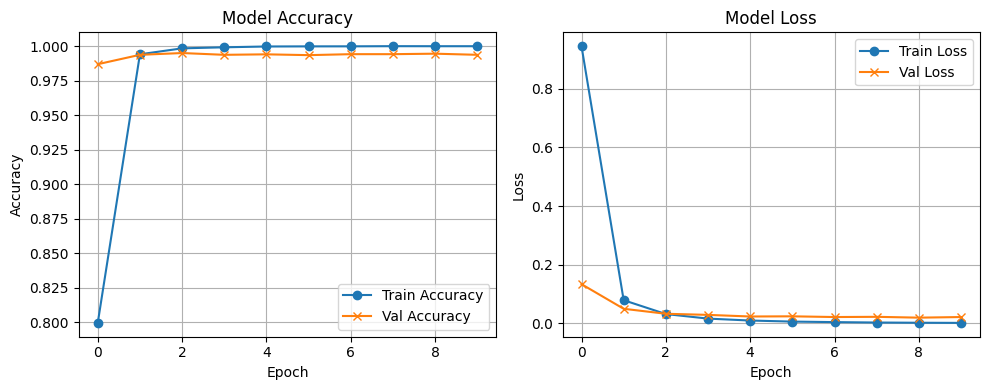

In [8]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
# prompt: save the model on my dreive

# === 8. Save the trained model to Google Drive ===
model_save_path = '/content/drive/MyDrive/ISL_Data/arun.keras' # Choose a desired path
model.save(model_save_path)
print(f"✅ Model saved successfully to: {model_save_path}")

✅ Model saved successfully to: /content/drive/MyDrive/ISL_Data/arun.keras


In [12]:
from tensorflow.keras.models import load_model

# Load saved model
model = load_model(model_save_path)

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image


def predict_sign(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


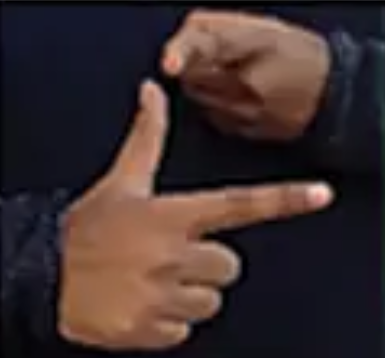

Predicted Sign: J


In [14]:
import numpy as np

# Get class labels from the training generator
class_labels = list(train_generator.class_indices.keys())

# Define image size (same as used during training)
image_size = (128, 128)
img_path='/content/drive/MyDrive/ISL_Data/test2.png'

# Load and preprocess the image using the predict_sign function
img_array = predict_sign(img_path)

# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_label = class_labels[predicted_class_index]

# Display the image
img = load_img(img_path)
display(img)

print("Predicted Sign:", predicted_label)